# Kinetikus gázmodell szimulációja

## Feladatkitűzés

A *kinetikus gázelmélet* egyike a legegyszerűbb modelleknek, melynek segítségével a gázok termo- és hidrodinamikai viselkedése leírható. Segítségével a gázok legfőbb *makroszkópikus jellemzői* megmagyarázhatóak, így például a *nyomás, térfogat, hőmérséklet*, vagy éppenséggel a *viszkozitás* és a *diffúzió*. 

Az **ideális gáz**t definiáljuk mint, nagyszámú, apró, gyorsmozgású golyók halmaza, melyek rendezetlen mozgásukkal - egymással és a tárolóedény falával rugalmasan ütközve - kitöltik a rendelkezésükre álló teret.

**Az ideális gázok modellje**:
- A részecskék száma kellően nagy ahhoz, hogy a *statisztikai leírás indokolt legyen* és a részecskék által kitöltött térfogat *homogén hőmérsékleteloszlású* legyen. `Sok... `
- Az ideális gáz részecskéi *nagyon kicsik*. Azaz a részecskék össztérfogata elhanyagolható a tárolóedény űrtartalmához képest. `...pici... `
- A gyorsmozgású részecskék egymással és az edény falával is folyamatosan, *pillanatszerűen és rugalmasan ütköznek*. Így a részecskéket modellezhetjük tökéletesen tömör gömbökként. `...piros pont száguldozik és ütközik... `
- Az ütközéseket leszámítva, a részecskék közti egyéb kölcsönhatásoktól eltekintünk. `...és kész.`

Rugalmas ütközés során, könnyen belátható, hogy az alábbiak szerint alakulnak az ütközés utáni sebeségek:
$\begin{equation} \mathbf{u}_1 = \mathbf{v}_1 - \frac{(\mathbf{v}_1-\mathbf{v}_2)\cdot(\mathbf{r}_1-\mathbf{r}_2)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_1-\mathbf{r}_2) \tag{1.1}\end{equation}$
$\begin{equation} \mathbf{u}_2 = \mathbf{v}_2 - \frac{(\mathbf{v}_2-\mathbf{v}_1)\cdot(\mathbf{r}_2-\mathbf{r}_1)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_2-\mathbf{r}_1) \tag{1.2}\end{equation}$
Ahol:
- $\mathbf{r}_i\in\mathbb{R}^2$ az $i$. indexű részecske helye
- $\mathbf{v}_i\in\mathbb{R}^2$ az $i$. indexű részecske sebessége az ütközés előtt
- $\mathbf{u}_i\in\mathbb{R}^2$ az $i$. indexű részecske sebessége az ütközés után

Feladatunk a modell elkészítése és vizualizációja `Matplotlib` library segítségével:
<p align="center">
  <img src="output.png?" width="400" />
</p>

## Megoldás

### Szükséges importok a feladatmegoldáshoz

In [34]:
import numpy as np                              # Alapvető matematikai eszköztár
import matplotlib.pyplot as plt                 # Plotoláshoz
import matplotlib
from matplotlib import animation                # Animációk készítéséhez
from matplotlib.animation import PillowWriter   # .gif formátumba való exportáláshoz
from itertools import combinations

### Kezdeti paraméterek inicializálása

Minden fizikai szimuláció kezdetekor **inicializáljuk az összes szükséges paramétert**! A kulcsmondat: `Sok, pici, piros pont száguldozik és ütközik és kész.` Azaz definiáljuk a részecskék számát, a részecskék méretét, emellett a helyét és a sebességét is!

Random számokat (egyenletes eloszlás alapján) az `np.random.random()` függvény segítségével tudunk generálni. Fontos, hogy ez a függvény $0$ és $1$ között egy *valós számot* generál! Az `np.random.uniform()` segítségével tetszőleges intervallumon tudunk random számokat generálni.

*<span style="color:teal">Megjegyzés: a kódolás elején célszerű inkább kevesebb és nagyobb pontot tekinteni! Több ezer pont esetén több 10 percet is igénybevehet a szimuláció lefutása, ez pedig nagyban megnehezíti a debuggolást!</span>* 

$\begin{bmatrix} 425 \\ -651 \end{bmatrix}$

In [35]:
# Az adatok definiálása
N = 100         # Részecskék száma
radius = 0.05   # Részecskék mérete


# Helyvektorok (R^2) inicializálása
r = np.random.random(
    (2, N)
)  # 0....1, A helypozíciókat egy 2 elemű, egyenként 100 számot tartalmazó tömben tároljuk, ahol az első százas tömbben az x, a másodikban az y koordináták szerepelnek


# Sebességvektorok (R^2) inicializálása
v = np.random.uniform(
    -500, 500, (2, N)
)  # az attribútumok közül a harmadiknál (a zárójelen belüli) azt adom meg, hogy két tömböt szeretnék, mindegyikben N db véletlenül generált számmal


# Felcímkézzük az egyes pontokat
IDs = np.arange(N)

Ezt követően ábrázoljuk a kezdeti állapotot!

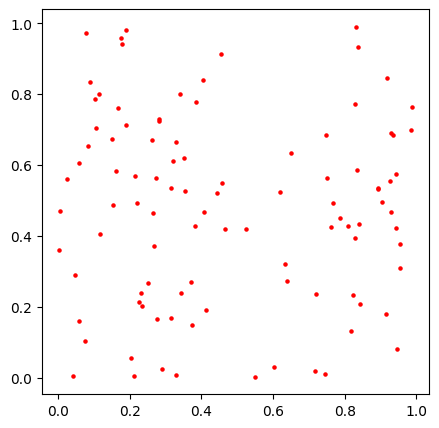

In [36]:
# Kezdeti állapot megjelenítése
plt.figure(figsize=(5, 5))
plt.scatter(r[0], r[1], color="r", s=5)  # r[0] az x, r[1] az y koordináta

plt.show()

### Ütközések szimulációja

A `Sok, pici, piros pont száguldozik és ütközik és kész.` kulcsmondat `Sok, pici, piros pont száguldozik` részét már sikeresen teljesítettük! Most pedig jöhet az `ütközik`, ami már egy fokkal bonyolultabb lépésekből áll.

Járjunk el a következő módon:
- **1. lépés**: Határozzuk meg az összes pontpár közti távolságot!
$$ d = \sqrt{\Delta x^2 + \Delta y^2}$$
- **2. lépés**: Ha $d < 2r$, akkor a rugalmas ütközés egyenletei alapján kiszámoljuk az új sebességeket.
- **3. lépés**: Ha a tárolóedény falával ütközik a részecske, akkor a falra merőleges sebességkomponens előjelet vált.

Így már tudjuk modellezni a mozgást!

#### 1. lépés: Pontpárok távolságának meghatározása

<p align="center">
  <img src="maneuver.png?" width="400" />
</p>

Páronként minden pont távolságát meg kell vizsgálnunk ahhoz, hogy eldöntsük, mely részecskék fognak ütközni. Ebben most mélyedjünk el egy pillanatra: $N=100$ pont esetén ez $100\cdot 99/2 = 4950$ távolságot definiál, $N=1000$ pontra ez már $499.500$ párt jelent! Tehát amíg $10$-szeresére növeltük a részecskék számát, a vizsgálandó párok száma $100$-szeresére, azaz $10^2$-szeresére nőtt!

A Computer Science nyelvén azt mondjuk, hogy ezen algoritmus komplexitása $\mathcal O(n^2)$ (ordó n-négyzetes, vagy kvadratikus idejű). Az $\mathcal O(n^2)$ komplexitás egyébként kimondottan rossz, és lassú futást eredményez nagy $N$ esetén. 

Az algoritmuselméletben az alábbi komplexitásokkal találkozhatunk gyakran:
- Gyors futási idő: $\mathcal O(1)$, $\mathcal O(\log n)$, $\mathcal O(\sqrt{n})$
- Közepes futási idő: $\mathcal O(n)$, $\mathcal O(n\log n)$
- Lassú futási idő: $\mathcal O(n^2)$, $\mathcal O(n^3)$, $\mathcal O(2^n)$, $\mathcal O(n!)$

In [37]:
# Felírjuk az összes párosítást
particalPairs = np.asarray(list(combinations(IDs, 2)))
print(particalPairs)



# Felírjuk az egyes pontok x és y koordinátáit


xPairs = np.array(
    [r[0][particalPairs[:, 0]], r[0][particalPairs[:, 1]]]
).T  # a pontpárokból készítek két olyan tömböt, amely az egyes párosítások x koordinátáit tartalmazza azonos indexen;  Úgy adom át az np.array-nek, hogy előtte egy tömbjelzésbe csomagolom
yPairs = np.array(
    [r[1][particalPairs[:, 0]], r[1][particalPairs[:, 1]]]
).T  # ugyanez y koordinátákkal pepitában;
# a .T transzponálással a két egyenként 4950 elemet tartalmazó tömbből készít 4950 elemű egyenként két elemet tartalmazó tömböt
print(xPairs)


# Kiszámítjuk x és y irányban az eltéréseket

ΔxPairs = np.diff(
    xPairs, axis=1
).ravel()  # ravel(), hogy az egyes számokat ne tömbbe helyezve tárolja
ΔyPairs = np.diff(yPairs, axis=1).ravel()
print(ΔxPairs)


# Ezt követően Pitagorasz-tétellel adódik a távolság
dPairs = np.sqrt(ΔxPairs**2 + ΔyPairs**2)
print(dPairs)

[[ 0  1]
 [ 0  2]
 [ 0  3]
 ...
 [97 98]
 [97 99]
 [98 99]]
[[0.95392875 0.29065343]
 [0.95392875 0.2684532 ]
 [0.95392875 0.00514992]
 ...
 [0.83621424 0.10264119]
 [0.83621424 0.80945422]
 [0.10264119 0.80945422]]
[-0.66327532 -0.68547555 -0.94877883 ... -0.73357305 -0.02676002
  0.70681303]
[0.72204289 0.68813313 0.96234466 ... 0.74816042 0.50365278 0.79136929]


#### 2. lépés: Ütközések modellezése

Feltételezzük, hogy azon részecskék fognak ütközni, melyek távolsága kisebb, mint $2r$, amikor már a részecskék egymásban lennének. A kinetikus gázmodellben feltételezzük az *energia-*, *lendület-* és *perdületmegmaradás*t, ezért a gázrészecskék között **pillanatszerű, rugalmas ütközés**t teszünk fel. 

Rugalmas ütközés során, könnyen belátható, hogy az alábbiak szerint alakulnak az ütközés utáni sebeségek:
$\begin{equation} \mathbf{u}_1 = \mathbf{v}_1 - \frac{(\mathbf{v}_1-\mathbf{v}_2)\cdot(\mathbf{r}_1-\mathbf{r}_2)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_1-\mathbf{r}_2) \tag{1.1}\end{equation}$
$\begin{equation} \mathbf{u}_2 = \mathbf{v}_2 - \frac{(\mathbf{v}_2-\mathbf{v}_1)\cdot(\mathbf{r}_2-\mathbf{r}_1)}{|\mathbf{r}_1-\mathbf{r}_2|^2}\cdot(\mathbf{r}_2-\mathbf{r}_1) \tag{1.2}\end{equation}$


In [38]:
# Ütköző párok meghatározása
collidePairs = particalPairs[dPairs < 2 * radius]
print(collidePairs)



# Sebességek definiálása
v1 = v[:, collidePairs[:, 0]]
v2 = v[:, collidePairs[:, 1]]


# Helyvektorok definiálása
r1 = r[:, collidePairs[:, 0]]
r2 = r[:, collidePairs[:, 1]]



# Az új sebességek
u1 = v1 - (((v1 - v2) * (r1 - r2).sum(axis=0)) / np.sum((r1 - r2) ** 2, axis=0)) * (
    r1 - r2
)
u2 = v2 - (((v2 - v1) * (r2 - r1).sum(axis=0)) / np.sum((r2 - r1) ** 2, axis=0)) * (
    r2 - r1
)


[[ 0 56]
 [ 1 19]
 [ 1 35]
 [ 1 90]
 [ 2 87]
 [ 3 33]
 [ 4  9]
 [ 4 50]
 [ 4 84]
 [ 5 74]
 [ 6 36]
 [ 6 45]
 [ 6 46]
 [ 8 17]
 [ 8 48]
 [ 8 58]
 [ 8 86]
 [10 29]
 [10 32]
 [11 66]
 [11 79]
 [12 24]
 [12 42]
 [12 54]
 [12 72]
 [13 18]
 [13 40]
 [13 88]
 [13 99]
 [14 37]
 [14 53]
 [14 75]
 [14 85]
 [15 51]
 [16 20]
 [16 25]
 [16 71]
 [16 82]
 [16 87]
 [16 93]
 [16 94]
 [17 48]
 [17 78]
 [18 34]
 [18 40]
 [18 72]
 [18 79]
 [18 88]
 [18 99]
 [19 35]
 [20 71]
 [20 82]
 [20 87]
 [20 94]
 [21 29]
 [21 37]
 [21 53]
 [21 69]
 [22 62]
 [23 28]
 [23 41]
 [23 49]
 [24 34]
 [24 42]
 [24 54]
 [24 66]
 [24 72]
 [25 87]
 [25 91]
 [25 93]
 [26 47]
 [26 55]
 [26 73]
 [26 96]
 [26 98]
 [28 41]
 [28 49]
 [29 32]
 [29 53]
 [29 69]
 [29 85]
 [30 34]
 [30 56]
 [30 72]
 [31 58]
 [31 80]
 [31 82]
 [31 86]
 [31 94]
 [32 69]
 [33 64]
 [34 42]
 [34 54]
 [34 56]
 [34 72]
 [36 43]
 [36 45]
 [36 67]
 [36 71]
 [37 53]
 [37 75]
 [37 85]
 [38 77]
 [40 79]
 [40 88]
 [40 99]
 [41 49]
 [42 54]
 [42 66]
 [42 72]
 [43 67]
 

#### Segéd lépés: Eddigiek összefoglalása függvényekbe

In [39]:
def Δxy_pairs(x, particle_pairs):
    return np.diff(
        np.array([x[particle_pairs[:, 0]], x[particle_pairs[:, 1]]]).T, axis=1
    ).ravel()


def d_pairs(r, particle_pairs):
    return np.sqrt(
        Δxy_pairs(r[0], particle_pairs) ** 2 + Δxy_pairs(r[1], particle_pairs)
    )


def collision(v1, v2, r1, r2):
    u1 = v1 - ((v1 - v2) * (r1 - r2)).sum(axis=0) / np.sum((r1 - r2) ** 2, axis=0) * (
        r1 - r2
    )
    u2 = v2 - ((v2 - v1) * (r2 - r1)).sum(axis=0) / np.sum((r1 - r2) ** 2, axis=0) * (
        r2 - r1
    )
    return u1, u2

#### 3. lépés: A mozgás leírása
Az animációt úgy készítjük el, hogy egy `t` "időtartamot", `dt` lépésközökkel végigjárunk. Az `r` és `v` változókban mindig egy adott aktuális állapotot tárolunk el, és ezeket összefüzzük egy `t` lépés hosszú tömbbökbe: `R`, `V`.

Amit minden `i`. iterációs lépésben meg kell vizsgálnunk:
- Mely részecskék fognak ütközni egymással? Mi lesz utána a sebességük?
- Mely részecskék fognak ütközni a fallal? Mi lesz utána a sebességük?
- Ha adottak a sebességek, akkor egyenesen vonalú egyenletes mozgással haladnak tovább a részecskék `dt` ideig: $\Delta r = v \cdot \Delta t$
- Ezáltal megkapjuk az aktuális `r[i]` és `v[i]` állapotokat, amiket az `R` és `V` sorozatokhoz hozzáfűzünk.

In [40]:
def motion(t, dt, r, v, radius, particalPairs):  # t az iterációs lépések száma
    # Inicializálás
    R = np.zeros((t, r.shape[0], r.shape[1]))
    V = np.zeros((t, v.shape[0], v.shape[1]))

    # Kezdeti állapotok
    R[0] = r.copy()
    V[0] = v.copy()

    # A megadott időlépéseken végig iterálunk
    for i in range(1, t):
        # Ütközés egymással
        cP = particalPairs[d_pairs(r, particalPairs) < 2 * radius]
        v1 = v[:, cP[:, 0]]
        v2 = v[:, cP[:, 1]]
        r1 = r[:, cP[:, 0]]
        r2 = r[:, cP[:, 1]]
        v1, v2 = collision(v1, v2, r1, r2)
        # Ütközés a fallal
        v[0, r[0] > 1] *= -1
        v[0, r[0] < 0] *= -1
        v[1, r[1] > 1] *= -1
        v[1, r[1] < 0] *= -1

        # Adott időegység alatt egyenes vonalon végzett egyenletes mozgás
        r += v * dt

        R[i] = r.copy()
        V[i] = v.copy()
    return R, V

### Szimuláció
Most már nincsen semmi dolgunk, csak összefoglalni az eddig megírt kódot és futtatni a szimulációt! Javaslom, hogy tekintsük át mik a bemenetei a rendszerre és milyen kimenetet szeretnénk látni! A kulcsmondat továbbra is: `Sok, pici, piros pont szágoldozik és ütközik és kész!`

Tehát a bemenetek:
- `sok`: részecskék száma - `N`
- `pici`: részecskék mérete - `radius`
- `száguldozik`: a részecskék helye - `r` és sebessége - `v`
- `ütközik`: a részecskepárok ütköznek - `particlePairs`

A kimenet pedig a mozgás maga lesz, azaz `t` idő alatt az `r` helyekből és `v` sebességekből álló sorozat: `R`, `V`

In [41]:
# Az adatok definiálása
N = 1000  # Részecskék száma
radius = 0.0015  # Részecskék sugara

# Helyvektorok (R^2) inicializálása
r = np.random.random((2, N))  # N db R^2-beli vektor

# Sebességvektorok (R^2) inicializálása
v = np.random.uniform(-750, 750, (2, N))  # N db R^2-beli vektor

# Felcímkézzük az egyes pontokat
IDs = np.arange(N)

# Elkészítjük a részecskepárokat
particle_pairs = np.asarray(list(combinations(IDs, 2)))

# Szimuláljuk a mozgást
R, V = motion(t = 1000, dt = 0.000008, radius = radius, particalPairs = particalPairs, r = r, v = v)

C:\Users\Pc\AppData\Local\Temp\ipykernel_12200\1684220219.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(


### Animáció

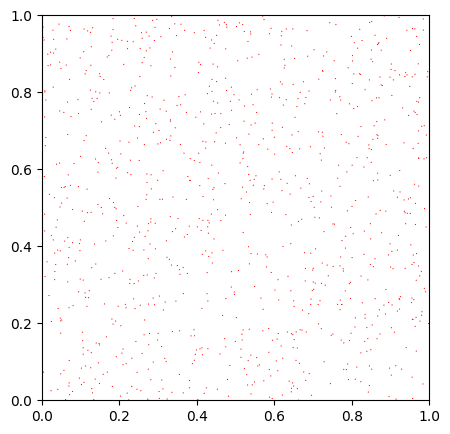

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x, y = R[0][0], R[0][1]
circles = [plt.Circle((xi, yi), radius = radius, linewidth = 0) for xi, yi in zip(x, y)]
cred = matplotlib.collections.PatchCollection(circles, facecolors = "red")
ax.add_collection(cred)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()

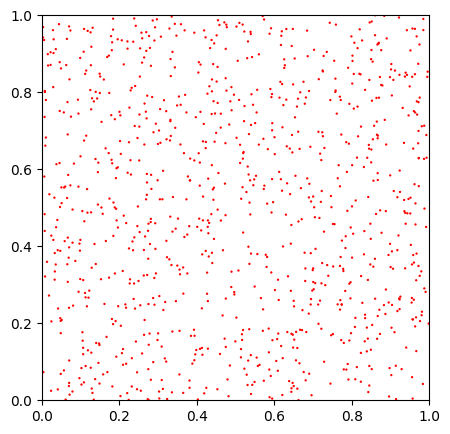

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


def animate(i):
    ax.clear()
    x, y = R[i][0], R[i][1]
    circles = [
        plt.Circle((xi, yi), radius = 2 * radius, linewidth = 0) for xi, yi in zip(x, y)
    ]
    cred = matplotlib.collections.PatchCollection(circles, facecolors = "red")
    ax.add_collection(cred)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)


ani = animation.FuncAnimation(fig, animate, frames = 1000, interval = 50)
ani.save("kinetic_gas3.gif", writer="pillow", fps = 30, dpi = 100)

# Epilógus

### Hasznos anyagok:

- Dokumentációk
    - Python hivatalos dokumentációja: https://docs.python.org/3/
    - [PEP 8](https://peps.python.org/pep-0008/) Style Guide for Python Code - Melyek a jó és rossz programozási praktikák
    - NumPy hivatalos dokumentációja: https://numpy.org/doc/1.25/
- Tankönyvek
    - [Dive Into Python 3](http://diveintopython3.problemsolving.io/)
    - [Dive into Deep Learning](https://d2l.ai/) - Interaktív tankönyv Deep Learninghez
    - [Fluent Python: Clear, Concise, and Effective Programming by Luciano Ramalho](https://www.oreilly.com/library/view/fluent-python/9781491946237/) - Haladóbb szemléletű Python programozás
- Útmutatók
    - [The Official Python Tutorial](https://docs.python.org/3/tutorial/) - Self-explanatory?
    - [Foglalt Keyword lista](https://docs.python.org/3.0/reference/lexical_analysis.html#id8) - Ezeket ne használd változónévnek!
    - [Codecademy](https://www.codecademy.com/catalog) - Interaktív (fizetős) online tutorial
    - [CheckIO](https://py.checkio.org/) - Tanulj Pythont játékfejlesztésen kersztül
- Competitive Programming
    - [Codewars](https://www.codewars.com/?language=python)
    - [CodeForces](https://codeforces.com/)

### Elérhetőség

Bármilyen kérdés, kérés vagy probléma esetén keressetek minket az alábbi elérhetőségeken:
- Monori Bence - m.bence02@outlook.hu
- Wenesz Dominik - weneszdominik@gmail.com

Illetve anonim üzenetküldésre is lehetőséget biztosítunk, ezt az alábbi linken tudjátok elérni: https://forms.gle/6VtGvhja3gq6CTT66